In [28]:
from copulae1 import *
import os

In [1393]:
import json
with open('../src/configs/config_coingecko_future_v1_MM.json','r') as file:
    config = json.load(file)
config

{'data_name': 'coingecko_future_v1',
 'spot_name': 'log return bitcoin',
 'future_name': 'log return future',
 'calibration_method': 'MM',
 'q_arr': [0.05, 0.1, 0.9, 0.95],
 'k_ERM': [10],
 'q_arr_ES': [0.01, 0.05, 0.1],
 'q_arr_VaR': [0.01, 0.05, 0.1],
 'h_Clip': [0, 99999]}

In [1394]:
data_name = config['data_name']
calibration_method  = config['calibration_method']
OHR = pd.read_hdf('../results/'+data_name +'/'+calibration_method+'/best_h.h5')


In [1416]:
if not os.path.exists("../results/" + data_name + "/MLE/reports"):
	print("Create new folder for results")
	os.mkdir("../results/" + data_name + "/MLE/reports")
	os.mkdir("../results/" + data_name + "/MM/reports")
    
if calibration_method == "MLE":
    report_path = "../results/" + data_name + "/MLE/reports/"
elif calibration_method == "MM":
    report_path = "../results/" + data_name + "/MM/reports/"

Create new folder for results


In [1396]:
natp_path = '../_mathematica/data/'
natp_ls = os.listdir(natp_path)
natp_h = [l for l in natp_ls if l.endswith('_h.csv')]
file_names = [l.replace('_h','') for l in natp_h]
OHR_combined = []
for i in range(len(natp_h)):
    _natp_h = pd.DataFrame(open(natp_path+natp_h[i], 'r').readlines())
    _natp_h = _natp_h.iloc[1:7,:]
    file_name = natp_h[i].replace('_h','')
    for i in range(len(_natp_h)):
        _natp_h.iloc[i,0] = np.float32(_natp_h.iloc[i,0].replace('\n',''))
    _natp_h.columns = ['NIG_factor']
    _natp_h.index = ['Variance', 'VaR q=0.01', 'VaR q=0.05', 'ES q=0.01', 'ES q=0.05', 'ERM k=10']
    _natp_h = _natp_h.T
    
    OHR_combined.append(OHR.loc[:,file_name].append(_natp_h))
    
OHR = pd.concat(OHR_combined, axis=1, keys=file_names).dropna(axis=1)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [1397]:
risk_measures = OHR.loc[:,'0.csv'].columns
data_path = '../processed_data/'+config['data_name']
ls = os.listdir(data_path +'/train/')
# OHR.loc[:,'0.csv'].loc[:,risk_measures[0]]

In [1398]:
h_arr = []
date_arr = []
for file in ls:
    test = pd.read_csv(data_path +'/test/'+file)
    test.Date = pd.to_datetime(test.Date)
    date_arr.append(test.Date[0])
    h_arr.append(OHR.loc['NIG_factor', file])

h_arr = pd.DataFrame(h_arr, index=date_arr)
h_arr = h_arr.sort_index()

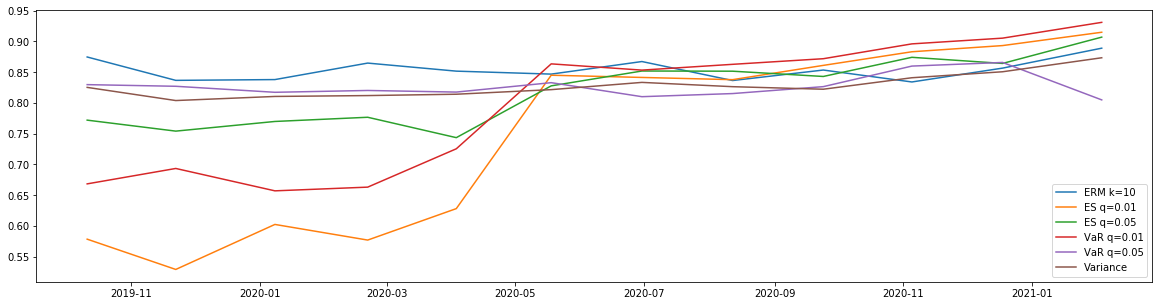

In [1399]:
plt.figure(figsize=(20,5))
for i, rm in enumerate(risk_measures):
    plt.plot(h_arr.iloc[:,i], label=rm)
# plt.plot(tau_arr, 'b--')
plt.legend()

In [1400]:
for i,r in enumerate(risk_measures):
    print(i, r)

0 ERM k=10
1 ES q=0.01
2 ES q=0.05
3 VaR q=0.01
4 VaR q=0.05
5 Variance


In [1401]:
# rm = 'ES q=0.05'
rm = risk_measures[1]
rm

'ES q=0.01'

In [1402]:
rh_arr = []
rs_arr = []
rf_arr = []
for file in ls:
    test = pd.read_csv(data_path +'/test/'+file)
    test.Date = pd.to_datetime(test.Date)
    rs = np.array(test.loc[:, config['spot_name']])
    rf = np.array(test.loc[:, config['future_name']])
    h_arr = OHR.loc[:,file].loc[:,rm]
    rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
    rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
    rh_arr.append(rh)
    
    rs = pd.Series(rs, index=test.Date)
    rf = pd.Series(rf, index=test.Date)
    rs_arr.append(rs)
    rf_arr.append(rf)
    
rh = pd.concat(rh_arr, axis=1)
rh = rh.sort_index(axis=1)
rs = pd.concat(rs_arr)
rs = rs.sort_index()

rf = pd.concat(rf_arr)
rf = rf.sort_index()

rh = rh.apply(pd.to_numeric)

In [1403]:
rh

Date,2019-08-30 00:00:00,2019-09-03 00:00:00,2019-09-04 00:00:00,2019-09-05 00:00:00,2019-09-06 00:00:00,2019-09-09 00:00:00,2019-09-10 00:00:00,2019-09-11 00:00:00,2019-09-12 00:00:00,2019-09-13 00:00:00,...,2021-01-21 00:00:00,2021-01-22 00:00:00,2021-01-25 00:00:00,2021-01-26 00:00:00,2021-01-27 00:00:00,2021-01-28 00:00:00,2021-01-29 00:00:00,2021-02-01 00:00:00,2021-02-02 00:00:00,2021-02-03 00:00:00
Gaussian,0.003277,0.005755,-0.004908,0.009965,0.000746,-0.006855,0.009438,0.000551,0.000607,0.000643,...,-0.013496,0.017577,-0.030735,0.036449,-0.010551,0.030860,-0.009151,-0.015167,-0.004489,0.011522
t_Copula,0.003650,0.010791,-0.004763,0.009090,0.000046,-0.007242,0.008081,0.000839,0.001849,0.000016,...,-0.015289,0.018518,-0.030764,0.035535,-0.010931,0.031534,-0.008012,-0.015656,-0.003298,0.012148
t_Copula_Capped,0.003384,0.007196,-0.004866,0.009715,0.000546,-0.006966,0.009050,0.000634,0.000962,0.000464,...,-0.014317,0.018008,-0.030748,0.036031,-0.010725,0.031169,-0.008629,-0.015391,-0.003944,0.011809
Clayton,0.004358,0.020367,-0.004488,0.007425,-0.001285,-0.007977,0.005499,0.001387,0.004210,-0.001177,...,-0.017847,0.019861,-0.030807,0.034231,-0.011472,0.032495,-0.006387,-0.016353,-0.001601,0.013042
Frank,0.005919,0.041489,-0.003881,0.003754,-0.004221,-0.009598,-0.000194,0.002595,0.009418,-0.003808,...,-0.037526,0.030191,-0.031134,0.024197,-0.015642,0.039890,0.006115,-0.021719,0.011460,0.019919
Gumbel,0.002778,-0.000996,-0.005102,0.011139,0.001685,-0.006337,0.011258,0.000165,-0.001057,0.001484,...,-0.009116,0.015278,-0.030662,0.038682,-0.009623,0.029215,-0.011933,-0.013973,-0.007395,0.009991
Plackett,0.003815,0.013034,-0.004698,0.008700,-0.000266,-0.007414,0.007476,0.000968,0.002402,-0.000263,...,-0.014072,0.017879,-0.030744,0.036156,-0.010673,0.031076,-0.008785,-0.015324,-0.004106,0.011723
Gauss Mix Indep,0.006546,0.049966,-0.003637,0.002280,-0.005400,-0.010249,-0.002479,0.003080,0.011508,-0.004865,...,-0.025388,0.023820,-0.030932,0.030385,-0.013070,0.035329,-0.001596,-0.018409,0.003404,0.015677
NIG_factor,0.005626,0.037516,-0.003995,0.004444,-0.003669,-0.009293,0.000877,0.002368,0.008438,-0.003314,...,-0.021737,0.021903,-0.030872,0.032247,-0.012297,0.033957,-0.003915,-0.017414,0.000981,0.014402


In [1404]:
tau_arr = []
date_arr = []
for file in ls:
    train = pd.read_csv(data_path +'/train/'+file)
    test = pd.read_csv(data_path +'/test/'+file)

    test.Date = pd.to_datetime(test.Date)
    date_arr.append(test.Date.iloc[0])
    
    train_tau = stats.kendalltau(train.loc[:,config['spot_name']], train.loc[:,config['future_name']])[0]
    test_tau = stats.kendalltau(test.loc[:,config['spot_name']], test.loc[:,config['future_name']])[0]

    tau_arr.append(train_tau - test_tau)

tau_arr = pd.Series(tau_arr, index=date_arr)
tau_arr = tau_arr.sort_index()
tau_arr.loc[rh.columns[0]] = tau_arr.iloc[0] # add a row for plotting
tau_arr = tau_arr.sort_index()

In [1405]:
# plt.figure(figsize=(20,5))
# plt.plot(rs, 'r')
# q = 0.05

# rs_U = rs.loc[rs<=np.quantile(rs,q)]
# plt.plot(np.array(rs_U.index),np.array(rs_U),'rx')

# rs_L = rs.loc[rs>np.quantile(rs,1-q)]
# plt.plot(np.array(rs_L.index),np.array(rs_L),'r+')

# rf_U = rf.loc[rf<=np.quantile(rf,q)]
# plt.plot(np.array(rf_U.index),np.array(rf_U),'bx')

# rf_L = rf.loc[rf>np.quantile(rf,1-q)]
# plt.plot(np.array(rf_L.index),np.array(rf_L),'b+')

# plt.plot(rf, 'b')

30


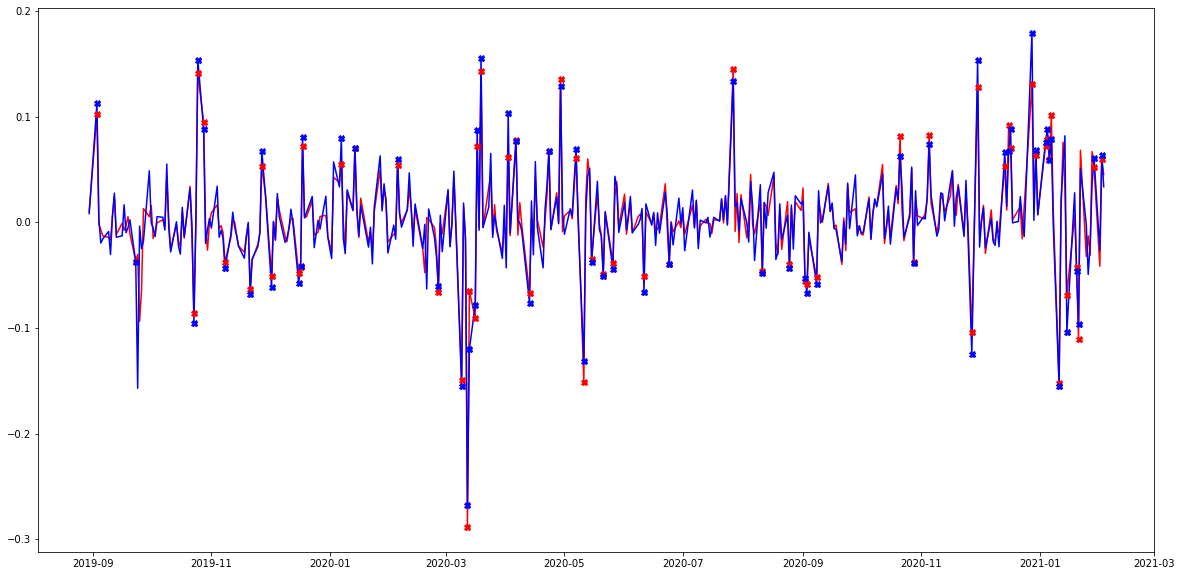

In [1406]:
plt.figure(figsize=(20,10))
q=0.1
print(np.sum(_id))
_id = (rs<=np.quantile(rs,q)) & (rf<=np.quantile(rf,q)) 
plt.plot(rs, 'r')
plt.plot(rf, 'b')
_id = (rs<=np.quantile(rs,q)) & (rf<=np.quantile(rf,q)) 
plt.plot(rs[_id],'rX')
plt.plot(rf[_id],'bX')

_id = (rs>np.quantile(rs,1-q)) & (rf>np.quantile(rf,1-q)) 
plt.plot(rs[_id],'rX')
plt.plot(rf[_id],'bX')

In [1407]:
# plt.figure(figsize=(20,5))
# plt.plot(rs, 'r')
# q = 0.1

# rs_U = rs.loc[rs<=np.quantile(rs,q)]
# plt.plot(np.array(rs_U.index),np.array(rs_U),'rx')

# rs_L = rs.loc[rs>np.quantile(rs,1-q)]
# plt.plot(np.array(rs_L.index),np.array(rs_L),'r+')

# rf_U = rf.loc[rf<=np.quantile(rf,q)]
# plt.plot(np.array(rf_U.index),np.array(rf_U),'bx')

# rf_L = rf.loc[rf>np.quantile(rf,1-q)]
# plt.plot(np.array(rf_L.index),np.array(rf_L),'b+')

# plt.plot(rf, 'b')

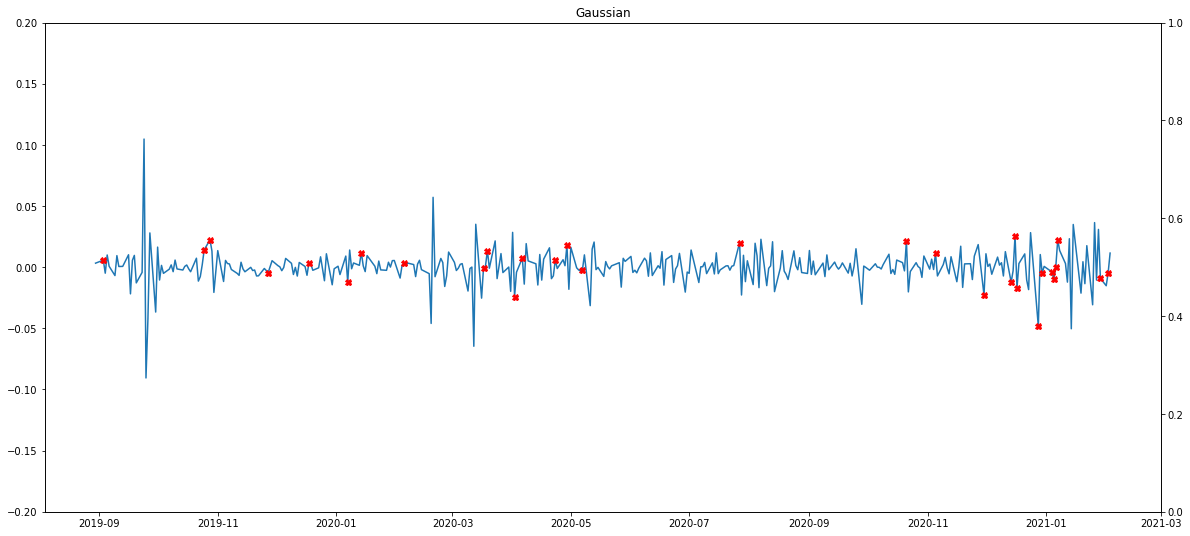

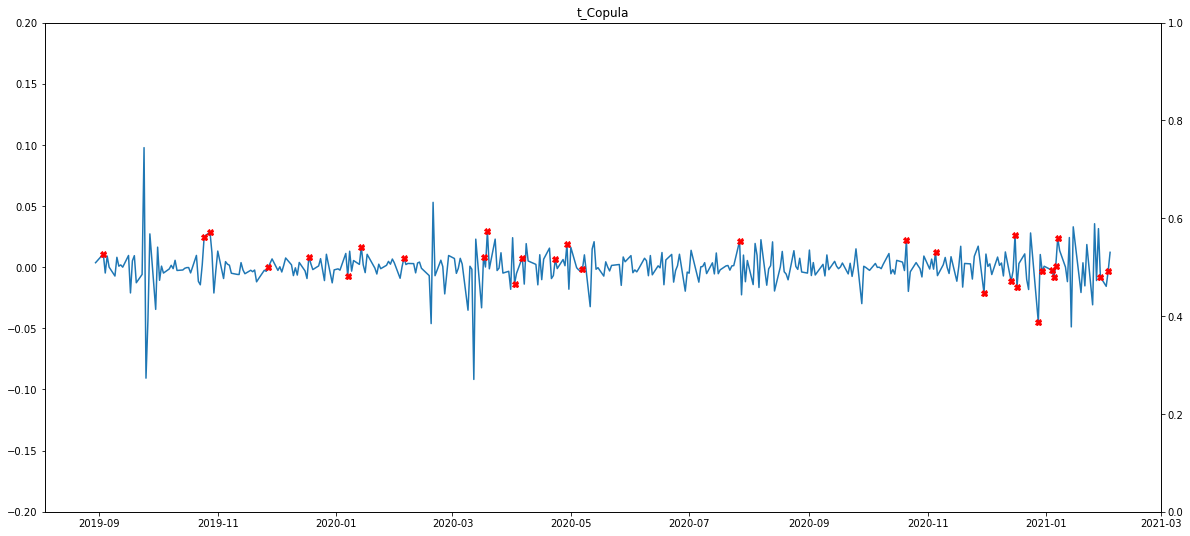

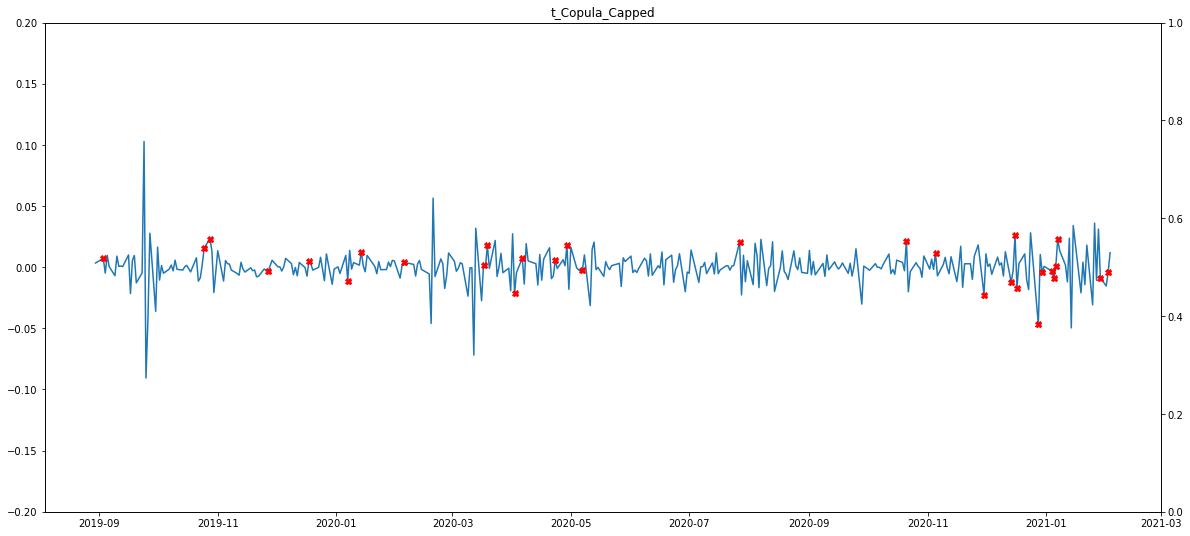

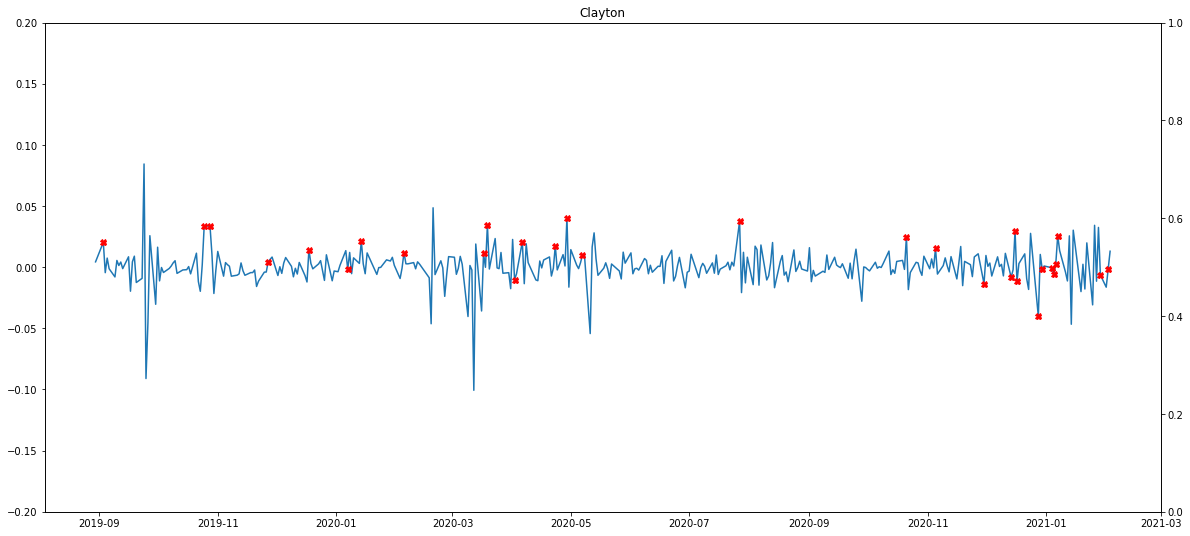

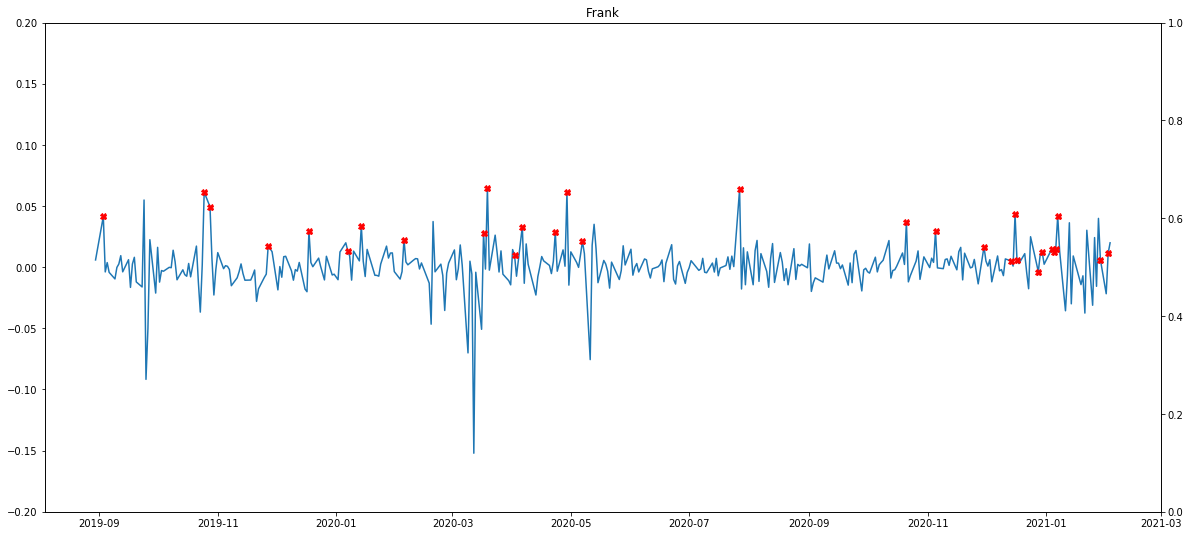

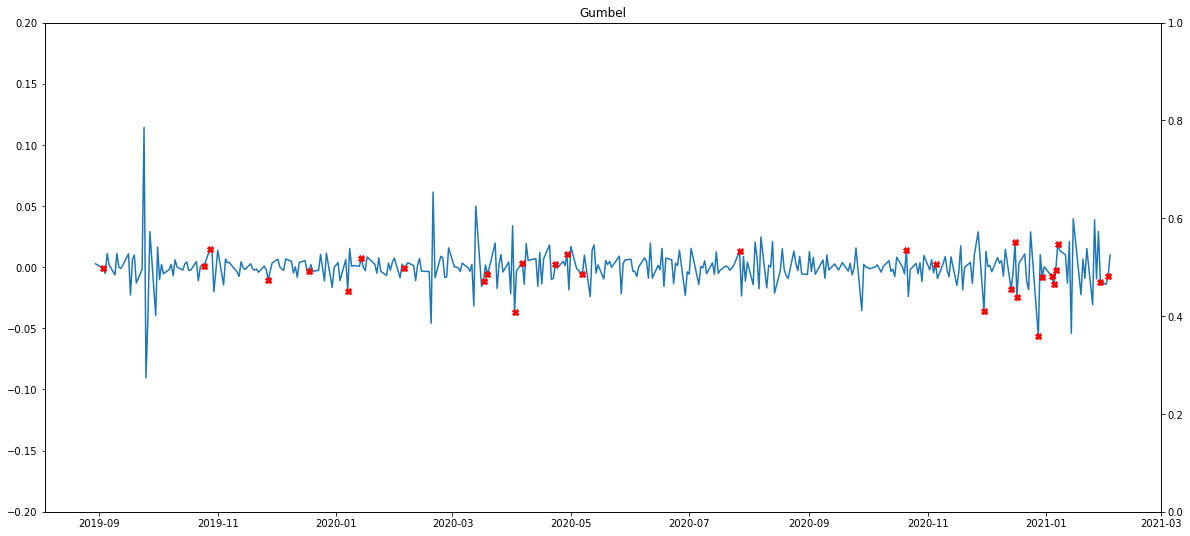

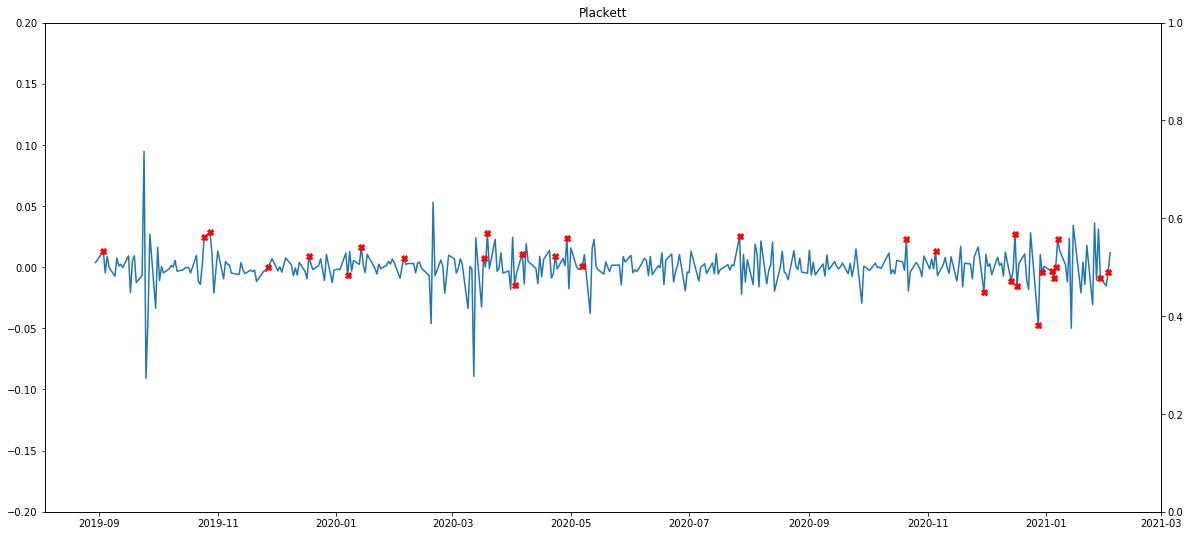

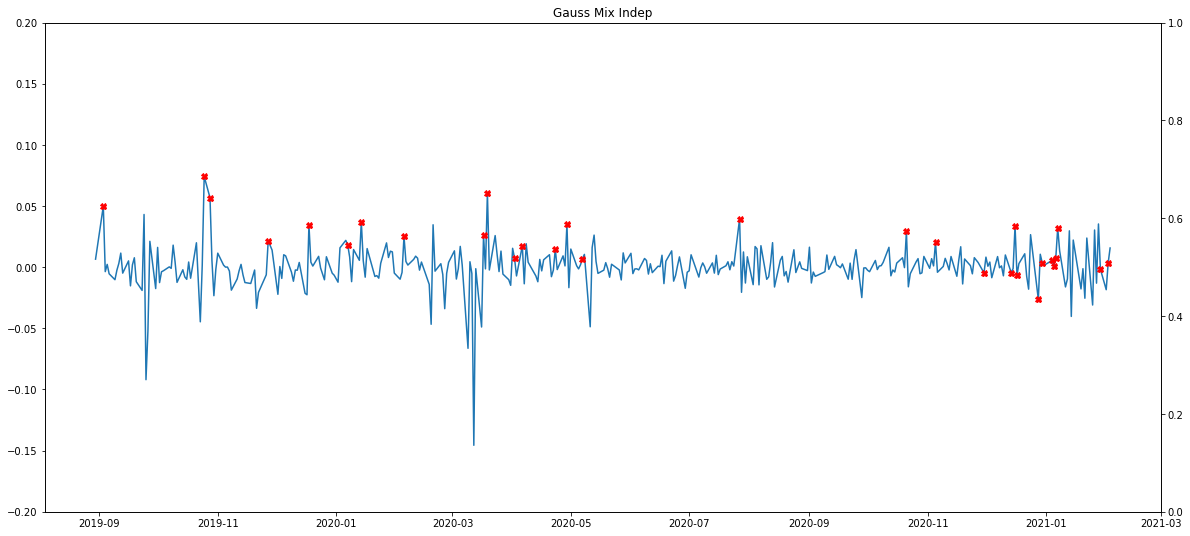

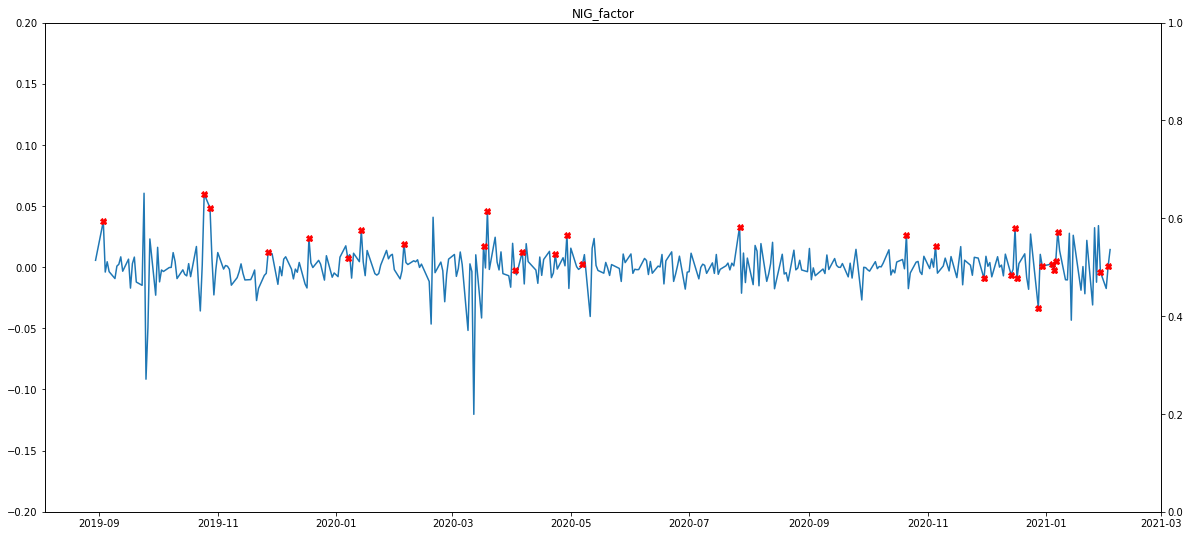

In [1408]:
for i in range(len(Copula_names)):
    fig, ax1 = plt.subplots(figsize=(20,1*len(Copula_names)))
    ax2 = ax1.twinx()  
    C = Copula_names[i]
#     plt.figure(figsize=(20,5))
    ax1.set_title(Copula_names[i])
    ax1.plot(rh.loc[C,:])
    ax1.plot(rh.T.loc[_id, C], 'rX')
    ax1.set_ylim((-0.2,0.2))

#     ax2.step(tau_arr.index, tau_arr)
#     ax2.set_ylabel(r'$\tau_{train} - \tau_{test}$')

#     plt.plot(rh.loc[C,rs_L.index],'rx')
#     plt.plot(rh.loc[C,rs_U.index],'r+')
#     plt.plot(rh.loc[C,rf_L.index],'bx')
#     plt.plot(rh.loc[C,rf_U.index],'b+')
#     plt.ylim((-0.2,0.2))
# plt.hlines(np.quantile(rh.loc[Copula_names[0],:], q), xmin=rh.columns[0], xmax=rh.columns[-1])
# plt.hlines(np.quantile(rh.loc[Copula_names[0],:], 1-q), xmin=rh.columns[0], xmax=rh.columns[-1])

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



mean       0.000166
std        0.016060
skew      -1.477246
kurt      12.454271
max        0.060455
UQ         0.007289
median     0.000029
LQ        -0.005988
min       -0.120322
dtype: float64


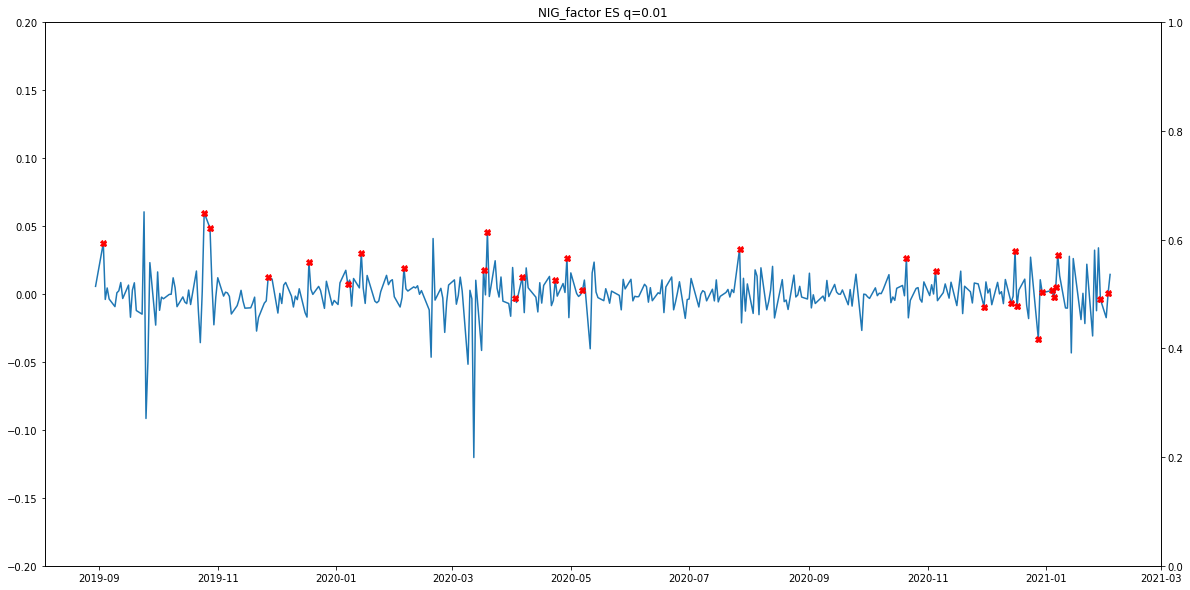

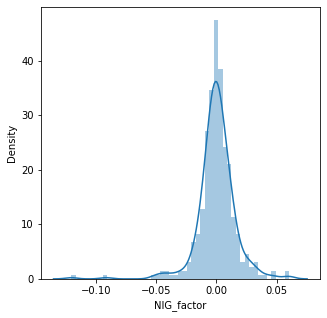

In [1409]:

fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()  
C = Copula_names[i]
#     plt.figure(figsize=(20,5))
ax1.set_title(Copula_names[i]+' '+rm)
ax1.plot(rh.loc[C,:])
ax1.plot(rh.T.loc[_id, C], 'rX')
ax1.set_ylim((-0.2,0.2))

_rh = rh.loc[C,:]
S = pd.Series({'mean':np.mean(_rh), 
 'std':np.std(_rh),
 'skew':stats.skew(_rh),
 'kurt':stats.kurtosis(_rh),
 'max': np.max(_rh),
 'UQ': np.quantile(_rh, 0.75),
 'median': np.quantile(_rh, 0.5),
 'LQ': np.quantile(_rh, 0.25), 
 'min':np.min(_rh)})
plt.figure(figsize=(5,5))
sns.distplot(_rh)
print(S)

In [1410]:
test = pd.read_csv(data_path +'/test/'+file)

h_arr = OHR.loc[:,file].loc[:,rm]
test.Date.iloc[-1]
h_arr.columns = [test.Date.iloc[-1]]

In [1411]:
C

'NIG_factor'

In [1412]:
dates = [pd.read_csv(data_path +'/test/'+file).iloc[-1,:].Date for file in ls]
end_date = _rh.index[-1]
h_4plot = pd.concat([OHR.loc[:, file].loc[:,rm] for file in ls],keys = dates, axis=1)
h_4plot = h_4plot.sort_index(axis=1)
h_4plot.loc[:,end_date] = h_4plot.iloc[:,-1]
a = go.Figure(go.Scatter(x=h_4plot.columns, y=h_4plot.loc[C,:], line= {"shape": 'hv'}))

In [1413]:
np.max(np.max(OHR))

1.1408203125000003

In [1417]:
from plotly.subplots import make_subplots

for rm in risk_measures:
    rh_arr = []
    rs_arr = []
    rf_arr = []
    for file in ls:
        test = pd.read_csv(data_path +'/test/'+file)
        test.Date = pd.to_datetime(test.Date)
        rs = np.array(test.loc[:, config['spot_name']])
        rf = np.array(test.loc[:, config['future_name']])
        h_arr = OHR.loc[:,file].loc[:,rm]
        rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
        rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
        rh_arr.append(rh)

        rs = pd.Series(rs, index=test.Date)
        rf = pd.Series(rf, index=test.Date)
        rs_arr.append(rs)
        rf_arr.append(rf)

    rh = pd.concat(rh_arr, axis=1)
    rh = rh.sort_index(axis=1)
    rs = pd.concat(rs_arr)
    rs = rs.sort_index()

    rf = pd.concat(rf_arr)
    rf = rf.sort_index()

    rh = rh.apply(pd.to_numeric)
    
    for C in Copula_names:
        _rh = rh.loc[C,:]

        fig = make_subplots(
            rows=3, cols=2,
            column_widths=[10, 10],
            row_heights=[10, 10, 10],
            specs=[[{"type":"xy","colspan": 2}, None],
                   [{"type":"xy","colspan": 2}, None],
                   [{"type": "histogram2d"}, {"type":"table"}]],
            subplot_titles=("Rh Time Series","OHR", "Histogram", "Rh Statistics"))
        
        # Line plot with extreme data points
        df = pd.DataFrame(_rh).reset_index()
        fig.add_trace(go.Scatter(x=df.loc[:,'Date'], y=df.loc[:,C]), row=1,col=1)
        fig.add_trace(go.Scatter(x=rh.T.loc[_id, C].index, y=rh.T.loc[_id, C],
                            mode='markers'))
        fig.update_yaxes(range=[-0.2, 0.2], row=1, col=1)

        
        # Step plot of h
        dates = [pd.read_csv(data_path +'/test/'+file).iloc[-1,:].Date for file in ls]
        end_date = _rh.index[-1]
        h_4plot = pd.concat([OHR.loc[:, file].loc[:,rm] for file in ls],keys = dates, axis=1)
        h_4plot = h_4plot.sort_index(axis=1)
        h_4plot.loc[:,end_date] = h_4plot.iloc[:,-1]
        fig.add_trace(go.Scatter(x=h_4plot.columns, y=h_4plot.loc[C,:], line= {"shape": 'hv'}),
                      row=2,col=1)
        fig.update_yaxes(range=[np.min(np.min(OHR))*1.1, np.max(np.max(OHR))*1.1], row=2, col=1)


        # Table
        S = pd.Series({'mean':np.mean(_rh), 
         'std':np.std(_rh),
         'skew':stats.skew(_rh),
         'kurt':stats.kurtosis(_rh),
         'max': np.max(_rh),
         'UQ': np.quantile(_rh, 0.75),
         'median': np.quantile(_rh, 0.5),
         'LQ': np.quantile(_rh, 0.25), 
         'min':np.min(_rh)})
        df = pd.DataFrame(S)
        df = df.reset_index()
        df.columns = ['Statistics', 'Value']
        fig.add_trace(go.Table(
            header=dict(values=list(df.columns),
                        fill_color='paleturquoise',
                        align='left'),
            cells=dict(values=[df.iloc[:,0],df.iloc[:,1]],
                       fill_color='lavender',
                       align='left'))
        , row=3,col=2)

        uq = np.quantile(_rh, .75)
        lq = np.quantile(_rh, .25)
        bw = 1.06*min(np.std(_rh), (uq-lq)/1.34)*len(_rh)**(-1/5)

        distplfig = ff.create_distplot([np.array(_rh)],
                                       ['rh'], bin_size=bw, show_rug=False)

        fig.add_trace(go.Histogram(distplfig['data'][0],
                                   marker_color='red'
                                  ), row=3, col=1)

        fig.update_layout(height=1000, width=1200, title_text=C+' '+rm)

        fig.write_html(report_path+C+"_"+rm+".html")

In [1291]:
import plotly.express as px
import plotly.graph_objects as go

df = pd.DataFrame(rh.loc[C,:]).reset_index()
fig = px.line(df, x='Date', y=C)
fig.add_trace(go.Scatter(x=rh.T.loc[_id, C].index, y=rh.T.loc[_id, C],
                    mode='markers'))



fig.show()

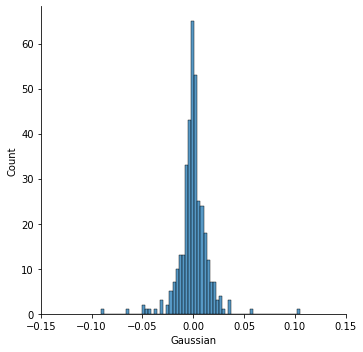

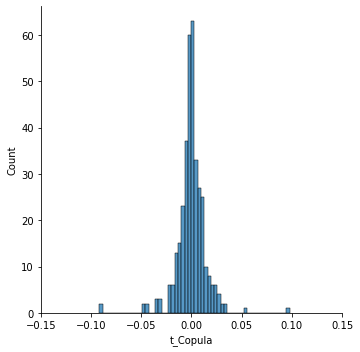

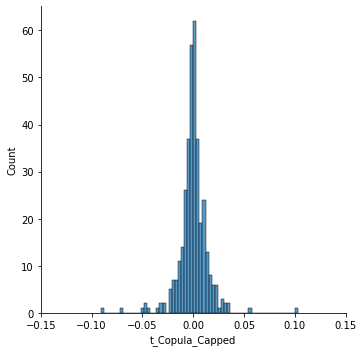

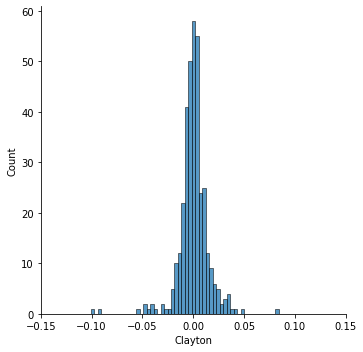

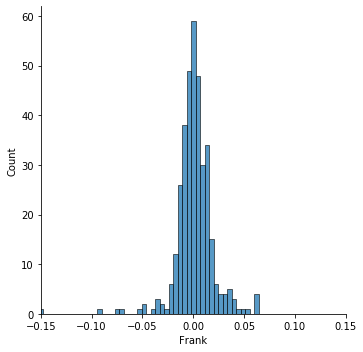

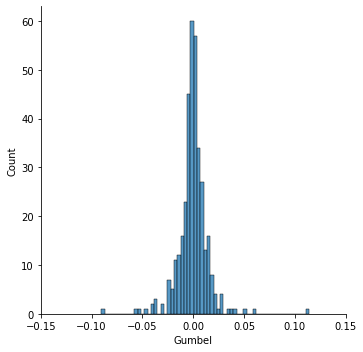

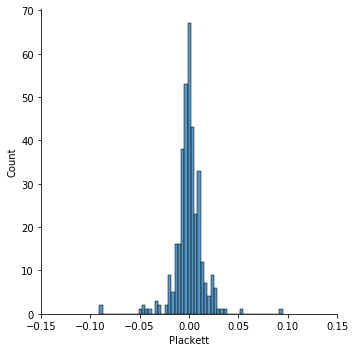

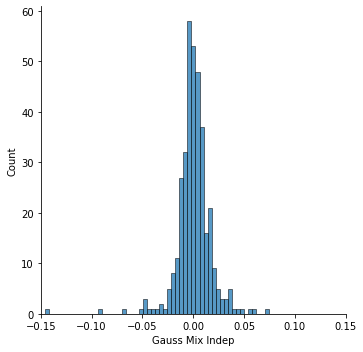

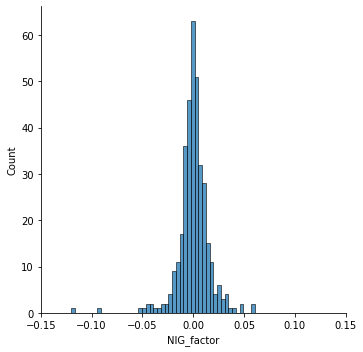

In [1047]:
for C in Copula_names:
    sns.displot(rh.loc[C,:])
    plt.xlim((-0.15,0.15))

[]

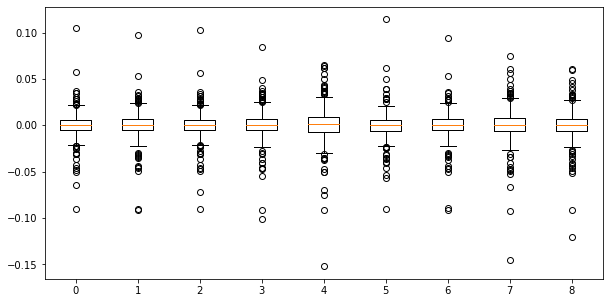

In [1048]:
plt.figure(figsize=(10,5))
plt.boxplot([rh.iloc[i, :] for i in range(len(rh))], positions=range(len(Copula_names)))
plt.plot()

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


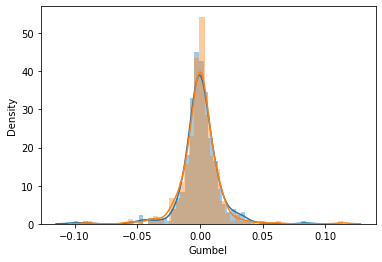

In [1049]:
sns.distplot(rh.loc['Clayton', :])
sns.distplot(rh.loc['Gumbel', :])

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


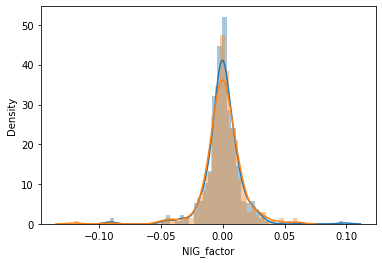

In [1060]:
sns.distplot(rh.loc['t_Copula', :])
sns.distplot(rh.loc['NIG_factor', :])

In [1062]:
ERM_estimate_trapezoidal(10, rh.loc['t_Copula', :])

0.021467969074562967

In [1063]:
ERM_estimate_trapezoidal(10, rh.loc['NIG_factor', :])

0.022830989549311505

In [1074]:
rm

'ES q=0.01'

In [1075]:
for C in Copula_names:
#     print(C, 1 - ES(0.1,rh.loc[C, :])/ES(0.1,rs))
#     print(C, 1 - ERM_estimate_trapezoidal(10,rh.loc[C, :])/ERM_estimate_trapezoidal(10,rs))
    print(C, 1 - ES(0.01,rh.loc[C, :])/ES(0.01,rs))


Gaussian 0.6575180598077344
t_Copula 0.6257141107513908
t_Copula_Capped 0.6507177829706179
Clayton 0.6052518133096332
Frank 0.47459697018853886
Gumbel 0.667178799755906
Plackett 0.6260121031510939
Gauss Mix Indep 0.5197999987062214
NIG_factor 0.577934148236584


In [1056]:
Copula_names

['Gaussian',
 't_Copula',
 't_Copula_Capped',
 'Clayton',
 'Frank',
 'Gumbel',
 'Plackett',
 'Gauss Mix Indep',
 'NIG_factor']

In [809]:
print(np.mean(rh.loc['Clayton', :]),
np.mean(rh.loc['Gumbel', :]))

0.00018558138285684528 -6.0850839062490733e-05


In [810]:
print(np.std(rh.loc['Clayton', :]),
np.std(rh.loc['Gumbel', :]))

0.014466019354131032 0.015625361141379857


In [811]:
print(stats.skew(rh.loc['Clayton', :]),
stats.skew(rh.loc['Gumbel', :]))

-0.26424923127996425 1.1508456013552986


In [812]:
print(stats.kurtosis(rh.loc['Clayton', :]),
stats.kurtosis(rh.loc['Gumbel', :]))

12.49085058110853 18.519603702214745


In [813]:
ERM_estimate_trapezoidal(10, rh.loc['Clayton', :])

0.02034899063891533

In [532]:
ERM_estimate_trapezoidal(10, rh.loc['Gumbel', :])

0.019976849049920663

In [758]:
C1 = Gaussian(dict(rho=0.9), Law_RS=stats.norm, Law_RF=stats.norm)  # fix the maringals!
C2 = t_Copula(dict(rho=0.1, nu=4), Law_RS=stats.norm, Law_RF=stats.norm, nu_lowerbound=2)
C2c = t_Copula(dict(rho=0.1, nu=4), Law_RS=stats.norm, Law_RF=stats.norm, nu_lowerbound=4)
C3 = Clayton(dict(theta=0.1), Law_RS=stats.norm, Law_RF=stats.norm)
C4 = Frank(dict(theta=0.1), Law_RS=stats.norm, Law_RF=stats.norm)
C5 = Gumbel(dict(theta=3), Law_RS=stats.norm, Law_RF=stats.norm)
C6 = Plackett(dict(theta=10), Law_RS=stats.norm, Law_RF=stats.norm)
C7 = Gaussian_Mix_Independent(dict(rho=.5, p=0.7), Law_RS=stats.norm, Law_RF=stats.norm)
Copulae_names = ['Gaussian', 't_Copula', 't_Copula_Capped', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep']
Copulae_arr = [C1, C2, C2c, C3, C4, C5, C6, C7]
Copulae = dict(zip(Copulae_names, Copulae_arr))

data_name = config['data_name']
calibration_method  = config['calibration_method']

if calibration_method == "MLE":
	paras = pd.read_json("../results/" + data_name + "/MLE/parameters.json")
elif calibration_method == "MM":
	paras = pd.read_json("../results/" + data_name + "/MM/parameters.json")


for C_name in Copulae:
    p = paras.loc[C_name, file]
    if (C_name == 't_Copula') or (C_name == 't_Copula_Capped'):
        Copulae[C_name].__init__(p, stats.norm, stats.norm, nu_lowerbound=2)
    else:
        Copulae[C_name].__init__(p, stats.norm, stats.norm)

s = Copulae[C_name].sample(10000)


stats.kendalltau(s[:,0], s[:,1])[0]

0.8199212321232122